## 4.데이터셋 분리 까진 같은 코드라 skip하셔도 됩니다

## 1. 데이터 다운로드 

~/aiffel/lyricist/data/lyrics에 데이터가 있음

In [1]:
! mkdir -p ~/aiffel/lyricist/models
! ln -s ~/data ~/aiffel/lyricist/data

ln: failed to create symbolic link '/aiffel/aiffel/lyricist/data/data': Read-only file system


## 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이  
 glob 를 활용하여 모든 txt 파일을 읽어온 후,  
 raw_corpus 리스트에 문장 단위로 저장

In [29]:
#준비한 파일 내용 확인
import os, re
import numpy as np
import tensorflow as tf
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []


##### 데이터 확인해보기

In [30]:
#몇개의 파일이 있지?
print(f'The number of lyrics : {len(txt_list)}')

The number of lyrics : 49


In [31]:
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("문장 총 개수:", len(raw_corpus))
print("Examples:\n", raw_corpus[:30])

문장 총 개수: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'", "Somethin' ain't right when we talkin'", "Look like you hidin' your problems", 'Really you never was solid', 'No, you can\'t "son" me', "You won't never get to run me", 'Just when shit look out of reach', 'I reach back like one, three', 'Like one, three, yeah [Pre-Hook]', "That's when they smile in my face", 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Whole time they wanna take my place', 'Yeah, I know they wanna take my place', 'I can tell that love is fake', "I don't trust a word you say", 'How you wanna clique up after your mistakes?',

## 3. 데이터 정제

##### 1) 정제함수 정의

In [32]:
#정제 함수 
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() 
    sentence = re.sub("\[.*\]*", " ", sentence)
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
    sentence = re.sub(r'[" "]+', " ", sentence) 
    sentence = re.sub(r"[^a-z?.!,¿,']+", " ", sentence) 
    sentence = sentence.strip() 
    sentence = '<start> ' + sentence + ' <end>' 
    return sentence

# 정제 결과 확인
print(preprocess_sentence(raw_corpus[1]))
print(preprocess_sentence(raw_corpus[13]))

<start> i've been down so long , it look like up to me <end>
<start> no , you can't son me <end>


##### 2) 함수로 정제된 문장 모으기

In [33]:
# 정제된 문장들 모으기
corpus = []

for sentence in raw_corpus:
    # 아무것도 없는 문장 건너뛰기
    if len(sentence) == 0: continue
        #건너뛰는 문장이 있는지 모르겠음 :이 데이터에 없는 것 같기 때문 
        #한다면 ]는 아닌가? 
        #verse라고 했을때도 그냥 알아서 벌스 부분 작사를 하면되는건가?
    if (sentence.count(' ')+1 > 15) : continue
    if sentence[-1] == ")": continue
    if sentence[-1] == "]": continue
        
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인
print(len(corpus))
corpus[:10]

159742


["<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 '<start> straight up to my face , straight up to my face <end>',
 "<start> i've been down so long , it look like up to me <end>",
 '<start> they look up to me <end>',
 "<start> i got fake people showin' fake love to me <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> somethin' ain't right when we talkin' <end>",
 "<start> look like you hidin' your problems <end>"]

##### 3) 토큰화

In [34]:
#토큰화

#15개 이상의 토큰을 가지면 제거 
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞추기-> 시퀀스 길이 맞추려고
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    #문장 길이 설정 해주기
    #total_data_text = list(tensor)
    #num_tokens = [len(tokens) for tokens in total_data_text]
    #max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    #maxlen = int(max_tokens)
    
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

#https://keras.io/ko/preprocessing/text/ : 토큰화 전처리

[[   2  145   99 ...   11    3    0]
 [   2   41  131 ...    0    0    0]
 [   2    6   34 ...    0    0    0]
 ...
 [   2   82  727 ...    0    0    0]
 [   2  213    3 ...    0    0    0]
 [   2    9 1409 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f32d08b0990>


In [35]:
#텐서 출력 해보기
print(tensor[:3])

#최대 15개까지만 토큰화된것 확인가능

[[   2  145   99   55   29  161    4   13  131   20   27   10   11    3
     0]
 [   2   41  131   27   10   11    3    0    0    0    0    0    0    0
     0]
 [   2    6   34  852  179 3086  852   36   10   11    3    0    0    0
     0]]


In [36]:
# tokenizer에 구축된 단어 사전의 인덱스 확인해보기

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : the
6 : i
7 : you
8 : and
9 : a
10 : to


In [37]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  

# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 145  99  55  29 161   4  13 131  20  27  10  11   3]
[145  99  55  29 161   4  13 131  20  27  10  11   3   0]


## 4. 데이터셋 분리

##### 1) 데이터셋 정의

In [38]:
#데이터셋 객체 생성
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256

steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

##### 2) 양방향 학습 데이터 준비  및 데이터 분리
데이터 데이터셋 구성하기 전으로 이동 시켜야 하는데 
해당 셀 급해서 여기다가 작성함...ㅎ 

In [40]:
# 양방향 학습 데이터 준비
#기존 말뭉치에서 start,end 제외시킨 new_corpus 생성

new_corpus = [] # 새로운 말뭉치 준비
for line in corpus:
    new_line = re.sub("(\<[a-z]+\>)", " ", line) # <start>, <end> 삭제
    new_line = new_line.strip() # 양쪽 공백 삭제
    new_corpus.append(new_line)
    
    
# Tokenization
tensor, tokenizer = tokenize(new_corpus) 

# 평가 데이터셋 분리
src_input = tensor[:, :-1] # 마지막 토큰을 잘라, 소스 문장 생성
tgt_input = tensor[:, 1:] # 첫 토큰을 잘라, 타겟 문장 생성

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)

[[ 143   97   53 ...    0    0    0]
 [  39  129   25 ...    0    0    0]
 [   4   32  850 ...    0    0    0]
 ...
 [  80  725   16 ...    0    0    0]
 [ 211    0    0 ...    0    0    0]
 [   7 1407  736 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f32ccdf1a50>
Source Train: (127793, 14)
Target Train: (127793, 14)
Source Val: (31949, 14)
Target Val: (31949, 14)


### 양방향 모델 생성, 학습

In [41]:
from keras.layers import Bidirectional

class TextGenerator_Bidirectional(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, dropout = 0.2, return_sequences=True))
        self.rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, dropout = 0.2, return_sequences=True))
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [42]:
'''
해당 부분 생략
embedding_size = 800
hidden_size = 2048  # 뱃사공
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)
'''

'\nembedding_size = 800\nhidden_size = 2048  # 뱃사공\nmodel = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)\n\n# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.\n# 지금은 동작 원리에 너무 빠져들지 마세요~\nfor src_sample, tgt_sample in dataset.take(1): break\n\n# 한 배치만 불러온 데이터를 모델에 넣어봅니다\nmodel(src_sample)\n'

In [43]:
#해당 부분 생략
#model.summary()

In [44]:
embedding_size = 256
hidden_size = 1024  # 뱃사공
#reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                           patience=2, mode="min", min_lr=0.05)

model = TextGenerator_Bidirectional(tokenizer.num_words + 1, embedding_size , hidden_size)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

hist = model.fit(enc_train, dec_train, 
              epochs=10,
              batch_size=256,
              validation_data=(enc_val, dec_val),
              verbose=1)
#https://velog.io/@peterpictor/%EB%94%A5%EB%9F%AC%EB%8B%9D-RNNLSTM

Epoch 1/10
500/500 [==============================] - 976s 2s/step - loss: 2.8264 - accuracy: 0.6137 - val_loss: 0.4916 - val_accuracy: 0.9236
Epoch 2/10
500/500 [==============================] - 391s 782ms/step - loss: 0.3547 - accuracy: 0.9424 - val_loss: 0.1858 - val_accuracy: 0.9703
Epoch 3/10
500/500 [==============================] - 392s 784ms/step - loss: 0.1005 - accuracy: 0.9816 - val_loss: 0.1154 - val_accuracy: 0.9820
Epoch 4/10
500/500 [==============================] - 391s 781ms/step - loss: 0.0322 - accuracy: 0.9943 - val_loss: 0.0958 - val_accuracy: 0.9854
Epoch 5/10
500/500 [==============================] - 391s 782ms/step - loss: 0.0137 - accuracy: 0.9977 - val_loss: 0.0874 - val_accuracy: 0.9868
Epoch 6/10
500/500 [==============================] - 392s 783ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.0825 - val_accuracy: 0.9877
Epoch 7/10
500/500 [==============================] - 1007s 2s/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0874 - val_

## 6. 시각화 (생략)

### 문장 생성

In [5]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    #end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
#        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        #padding만 있는 인덱스는 그냥 넘겨주기
        if word_index == 0:
            continue
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
print(generate_text(model, tokenizer, init_sentence="<start> i love"))
print(generate_text(model, tokenizer, init_sentence="<start> you"))
print(generate_text(model, tokenizer, init_sentence="<start> he make"))
print(generate_text(model, tokenizer, init_sentence="<start> i did"))

<unk> i love you ? 
<unk> you got dada dada, witcha 
    
#파일 셧다운 된채로 run을 돌려버려서 생성된 문장 결과가 날라감
#모델 재학습이 어려워서, 생성된 문장 기록해둔거 복붙 ㅎ..
#가영아 잘하자...^^ 

## 회고

##### 💚양방향 LSTM
앞에서 부터의 단어 배치에 대한 확률만을 학습하는 것이 아니라  
뒤에서 부터도 학습하는 내용
(forward pass와 backward pass 모두로 학습하는 것)  
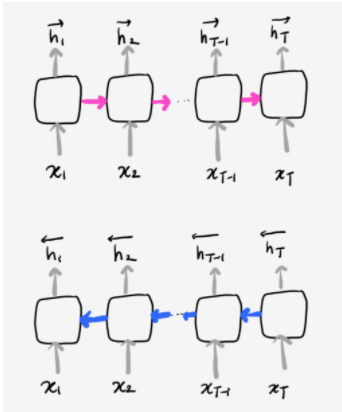
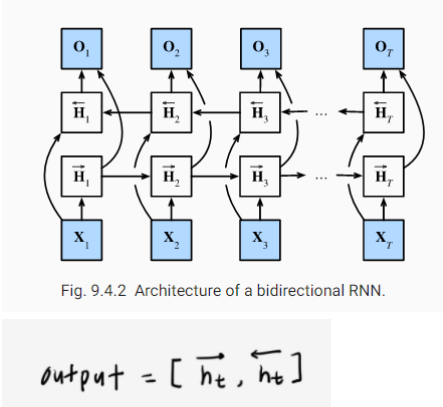

양방향 LSTM (코드화해서 설명 되어있음)    
https://wegonnamakeit.tistory.com/25

RNN과 LSTM 비교  
간단한 설명  
https://velog.io/@peterpictor/%EB%94%A5%EB%9F%AC%EB%8B%9D-RNNLSTM  
디테일한 설명  
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/  
(핵심 내용만 이해, 그림 보면서 흐름을 정확히 설명할 수 있을 만큼 읽고 이해해보기) 

##### 💚결과에 대한 회고   
양방향 LSTM을 사용해서 학습했지만,  
**1) val_loss 값이 높아지다가 다시 낮아지는 현상 발생**  
예전에 퍼실님께서  
에포크가 돌면서 가중치가 최적으로 가는게 아니라  
빙글빙글 돌면서 가느라  
loss값이 오르락 내리락 하는건 당연한거다  
과적합이라고 보기 어렵다고 말씀해주셨는데,,,  
loss, val_loss 모두 왔다리 갔다리 하지만 내려가고 있는것 같아보여서  
과적합은 아닌 것 같음  
하지만 과적합이 아니여도 어떤 다른 문제가 있기 때문에  
좋은 작사가 모델을 만들지 못한것이라고 판단됨  
여기서 문제가 무엇인지 계속 고찰해봐야할 필요성이 있음  

**2) 제대로 작사하지 못함**  
loss가 2.2 이하로 내려갔지만, 무의미하다고 판단됨  
결국 직접 문장을 생성시켜 보았을때  
제대로된 문장을 작사해내지 못함  
 i love -> i love you ? 
 you -> you got dada
dada, witcha 등 노래 가사여서  
영어권 내에서 쓰는 슬랭들이 많아 제대로 작사가 안되려나 싶었는데  
다른 결과물들과 비교해보니,,  
확연히 문장 구성력이 떨어짐  

##### 💚배운점 
1. 양방향 LSTM 에 대한 개념을 학습할 수 있었음  
2. RNN과 LSTM의 차이점에 대해서 공부할 수 있었음  
3. dropout에 대한 정확한 개념과 직접 적용해볼 수 있었음  

##### 💚개선하고 싶은점  
1. 제출이 20분 밖에 안남았는데,, 
하이퍼 파라미터에 수정한 모델이 아직 2개 더 돌아가는 중임 ㅠ   
해당 결과에 대해서.. 좋은 결과가 나오면 추후 해당 내용 업데이트를 할 예정  

2. 양방향 LSTM 코드에도  
하이퍼 파라미터 최적화를 사용하여 개선시켜보고 싶음  